## Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [4]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
#from torch.utils.data.dataset import Subset

In [5]:
import pandas as pd

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from tqdm.notebook import tqdm

In [8]:
import cv2
from google.colab.patches import cv2_imshow

In [9]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dataset

### データの読み込み

In [10]:
def makeDataList(csv_path):
  datalist = pd.read_csv(csv_path)
  return datalist

In [11]:


datalist = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/train.csv")

In [12]:
datalist.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
train_datalist, test_datalist = train_test_split(datalist, test_size=0.1, random_state=1234, shuffle=True)

In [14]:
print(train_datalist.shape)
print(test_datalist.shape)
print(train_datalist.values)
train_datalist.head()

(37800, 785)
(4200, 785)
[[5 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]
 ...
 [9 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10037,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13376,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13038,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3805,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3464,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Datasetの作成

In [15]:
#DataFrameからndarrayに変換.　Datasetを継承し，DataLoaderの第一引数にできる．
class DatasetMaker(Dataset):
  def __init__(self, datalist, transform=None):
    self.input_datalist = datalist.drop(["label"], axis=1).values.astype(np.float32).reshape(-1, 28, 28)
    self.label_datalist = datalist["label"].values.astype(np.int64)
    self.transform = transform

  def __len__(self):
    return len(self.input_datalist)

  def __getitem__(self, index):
    inputs = self.input_datalist[index]
    inputs = self.transform(inputs)
    labels = self.label_datalist[index]
    return inputs, labels

In [16]:
class ImageTransform():
  def __init__(self, mean=0, std=255):
    self.data_transform = transforms.Compose([

        transforms.ToTensor(),
        transforms.Resize(56),
        transforms.Normalize(mean, std),
    ])
  def __call__(self, img):
    return self.data_transform(img)

In [17]:
#デフォルトでは引数がindexではなくidxのため定義しなおしてみる．
class Subset(DatasetMaker):
    """
    Subset of a dataset at specified indices.

    Arguments:
        dataset (Dataset): The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)

In [18]:
trainval_dataset = DatasetMaker(train_datalist, transform=ImageTransform(mean=0, std=255))
n_samples = len(trainval_dataset)
train_size = int(n_samples * 0.8)

train_indices = list(range(0, train_size))
val_indices = list(range(train_size, n_samples))

train_dataset = Subset(trainval_dataset, train_indices)
val_dataset = Subset(trainval_dataset, val_indices)

test_dataset = DatasetMaker(test_datalist, transform=ImageTransform(mean=0, std=255))
print(train_dataset.__len__())
print(val_dataset.__len__())
#print(train_dataset.__getitem__(index=0)[0])
#print(train_dataset.__getitem__(index=0)[1])

30240
7560


torch.Size([1, 56, 56])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


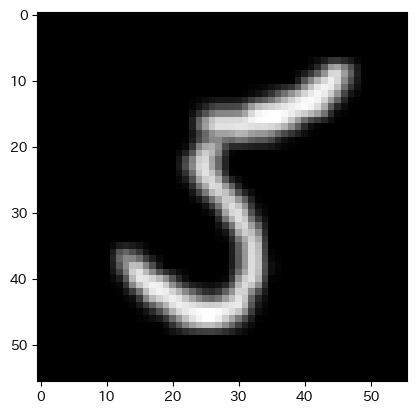

In [19]:
tmp = train_dataset.__getitem__(index=0)[0]
print(tmp.shape)
tmp = torch.squeeze(tmp)
plt.imshow(tmp.detach().numpy().copy(), cmap="gray")
plt.show()

## DataLoader

In [20]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=True)
dataloaders_dict = {"train":train_dataloader, "val":val_dataloader, "test":test_dataloader}
for inputs_tmp, labels_tmp in test_dataloader:
  break
#batch_itr = iter(dataloader)
#inputs, labels = next(batch_itr)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

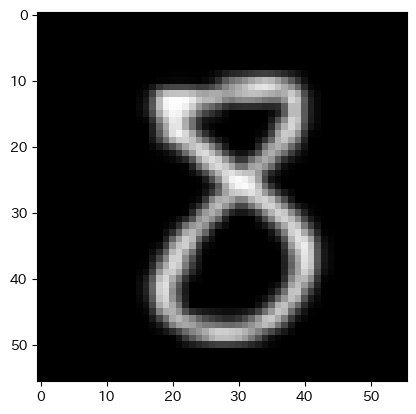

tensor([8, 3, 1,  ..., 8, 2, 1])
torch.Size([4200])


In [21]:
print(inputs_tmp)
print(inputs_tmp.size())
plt.imshow(inputs_tmp[0].detach().numpy().copy().reshape(56, 56), cmap="gray")
plt.show()
print(labels_tmp)
print(labels_tmp.size())

## Network

In [22]:
use_pretrained = True
net = models.densenet121(pretrained = use_pretrained)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 84.0MB/s]


In [23]:
print(net)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [24]:
net.features[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [25]:
summary(net, (64, 1, 56, 56))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [64, 1000]                --
├─Sequential: 1-1                        [64, 1024, 1, 1]          --
│    └─Conv2d: 2-1                       [64, 64, 28, 28]          3,136
│    └─BatchNorm2d: 2-2                  [64, 64, 28, 28]          128
│    └─ReLU: 2-3                         [64, 64, 28, 28]          --
│    └─MaxPool2d: 2-4                    [64, 64, 14, 14]          --
│    └─_DenseBlock: 2-5                  [64, 256, 14, 14]         --
│    │    └─_DenseLayer: 3-1             [64, 32, 14, 14]          45,440
│    │    └─_DenseLayer: 3-2             [64, 32, 14, 14]          49,600
│    │    └─_DenseLayer: 3-3             [64, 32, 14, 14]          53,760
│    │    └─_DenseLayer: 3-4             [64, 32, 14, 14]          57,920
│    │    └─_DenseLayer: 3-5             [64, 32, 14, 14]          62,080
│    │    └─_DenseLayer: 3-6             [64, 32, 14, 14]    

## Loss Function

In [26]:
criterion = nn.CrossEntropyLoss()

## Optimizer

In [27]:
# 学習率に傾斜をかける（最後に近づくほど高い学習率に）．
# パラメータを，featuresモジュールのパラメータ，最後の全結合層以外の全結合層のパラメータ，最後の全結合層のパラメータに分けて管理．
params_to_update_1 = []
params_to_update_2 = []

update_param_names_1 = ["features"]
update_param_names_2 = ["classifier"]

for name, param in net.named_parameters():
  if update_param_names_1[0] in name:
    param.requires_grad = True
    params_to_update_1.append(param)
    print("params_to_update_1に格納：", name)
  elif update_param_names_2[0] in name:
    param.requires_grad = True
    params_to_update_2.append(param)
    print("params_to_update_2に格納：", name)
  else: # ここに属するパラメータはないはず．
    param.requires_grad = False
    print("勾配計算なし．学習しない：", name)

params_to_update_1に格納： features.conv0.weight
params_to_update_1に格納： features.norm0.weight
params_to_update_1に格納： features.norm0.bias
params_to_update_1に格納： features.denseblock1.denselayer1.norm1.weight
params_to_update_1に格納： features.denseblock1.denselayer1.norm1.bias
params_to_update_1に格納： features.denseblock1.denselayer1.conv1.weight
params_to_update_1に格納： features.denseblock1.denselayer1.norm2.weight
params_to_update_1に格納： features.denseblock1.denselayer1.norm2.bias
params_to_update_1に格納： features.denseblock1.denselayer1.conv2.weight
params_to_update_1に格納： features.denseblock1.denselayer2.norm1.weight
params_to_update_1に格納： features.denseblock1.denselayer2.norm1.bias
params_to_update_1に格納： features.denseblock1.denselayer2.conv1.weight
params_to_update_1に格納： features.denseblock1.denselayer2.norm2.weight
params_to_update_1に格納： features.denseblock1.denselayer2.norm2.bias
params_to_update_1に格納： features.denseblock1.denselayer2.conv2.weight
params_to_update_1に格納： features.denseblock1.den

In [28]:
optimizer = optim.SGD([
  {"params": params_to_update_1, "lr": 1e-3},
  {"params": params_to_update_2, "lr": 2e-3},
], momentum=0.9)

## Train

In [29]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs, device):
  net.to(device)

  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    print("--------------")

    for phase in ["train", "val"]:
      if phase == "train":
        net.train()
      else:
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      for inputs, labels in tqdm(dataloaders_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, dim=1)

          if phase == "train":
            loss.backward()
            optimizer.step()

          epoch_loss += loss.item() * inputs.size(0)
          epoch_corrects += torch.sum(preds.data == labels.data)
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
      print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

In [ ]:
num_epochs = 16

train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 1.0688 Acc: 0.8362


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.1110 Acc: 0.9495
Epoch 2/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0701 Acc: 0.9779


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0830 Acc: 0.9601
Epoch 3/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0324 Acc: 0.9893


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0763 Acc: 0.9627
Epoch 4/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0177 Acc: 0.9948


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0695 Acc: 0.9630
Epoch 5/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

train Loss: 0.0102 Acc: 0.9967


  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.0668 Acc: 0.9646
Epoch 6/16
--------------


  0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:

save_weights_path = '/content/drive/MyDrive/Colab Notebooks/kaggle-digit-recognizer/digit-recognizer04/model.pth'
torch.save(net.state_dict(), save_weights_path)

## 評価

In [ ]:
def Evaluator():
  for inputs, labels in dataloaders_dict["test"]:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, dim=1)

    corrects = torch.sum(preds == labels)
    print("acc:{}".format(corrects/len(dataloaders_dict["test"].dataset)))
    print("loss:{}".format(loss))

In [ ]:
Evaluator()

## 結果

In [ ]:
class AnsDatasetMaker(Dataset):
  def __init__(self, datalist, transform=None):
    self.input_datalist = datalist.values.astype(np.float32).reshape(-1, 28, 28)
    self.transform = transform

  def __len__(self):
    return len(self.input_datalist)

  def __getitem__(self, index):
    inputs = self.input_datalist[index]
    inputs = self.transform(inputs)
    return inputs

In [ ]:
ans_datalist = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/test.csv")
ans_datalist.head()

In [ ]:
batch_size = 128
ans_dataset = AnsDatasetMaker(ans_datalist, transform=ImageTransform(mean=0, std=255))
ans_dataloader = DataLoader(ans_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [ ]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)
net.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
net.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/kaggle-digit-recognizer/digit-recognizer04/model.pth'))

In [ ]:
def Prediction(net, dataloaders_dict, device):
  net.to(device)
  net.eval()
  preds = torch.tensor([]).to(device)

  for inputs in tqdm(ans_dataloader):
    inputs = inputs.to(device)
    with torch.no_grad():
      outputs = net(inputs)
      _, batch_preds = torch.max(outputs, dim=1)
      preds = torch.cat((preds, batch_preds), dim=0)

  return preds

In [ ]:
preds = Prediction(net, ans_dataloader, device)

In [ ]:
print(preds)
print(preds.shape)

In [ ]:
submission = makeDataList("/content/drive/MyDrive/ColabData/kaggle-digit-recognizer/sample_submission.csv")
submission = submission.drop("Label", axis = 1)
print(submission.shape)
submission.head()

In [ ]:
preds_df = pd.DataFrame({"Label": preds.to("cpu").detach().numpy().copy()})
preds_df = preds_df.astype('int')
submission = pd.concat([submission, preds_df], axis=1)

In [ ]:
submission.head()

In [ ]:
print(submission.dtypes)
submission = submission.astype('int64')
print(submission.dtypes)

In [ ]:
save_csv_path = "/content/drive/MyDrive/Colab Notebooks/kaggle-digit-recognizer/digit-recognizer04/submission.csv"
submission.to_csv(save_csv_path, index=False)